In [3]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import random

(-0.5, 799.5, 639.5, -0.5)

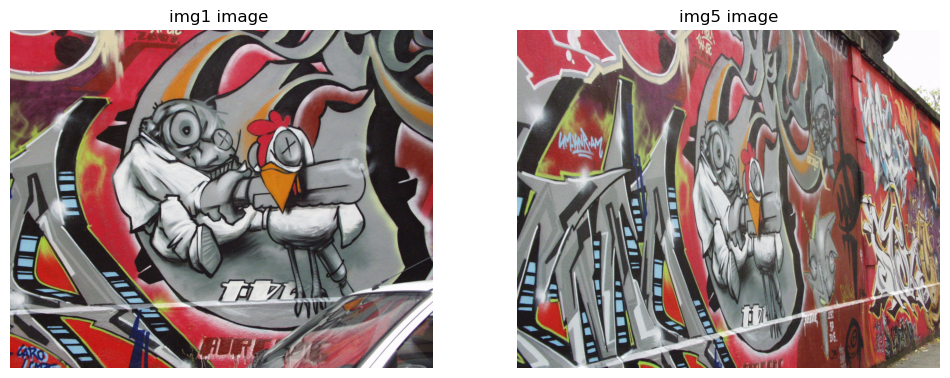

In [4]:
img1 = cv.imread('../../graf/img1.ppm')
img5= cv.imread('../../graf/img5.ppm')


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(cv.cvtColor(img1, cv.COLOR_BGR2RGB))
plt.title('img1 image ')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv.cvtColor(img5, cv.COLOR_BGR2RGB))
plt.title('img5 image')
plt.axis('off')



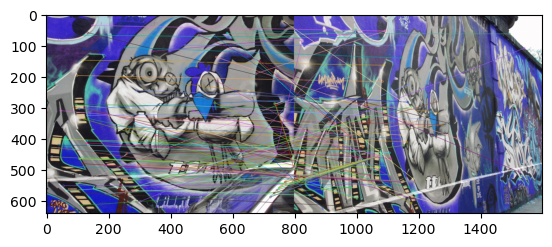

(<matplotlib.image.AxesImage at 0x21d24af65e0>, None)

In [14]:
# Convert images to grayscale
gray1 = cv.cvtColor(img1, cv.COLOR_BGR2GRAY)
gray5 = cv.cvtColor(img5, cv.COLOR_BGR2GRAY)

# Create a SIFT detector
sift = cv.SIFT_create(nOctaveLayers = 3,contrastThreshold = 0.09, edgeThreshold = 25, sigma = 1) 

# Detect keypoints and compute descriptors
kp1, des1 = sift.detectAndCompute(gray1, None)
kp5, des5 = sift.detectAndCompute(gray5, None)

# Use BFMatcher to find the best matches between descriptors
bf = cv.BFMatcher()
matches = bf.knnMatch(des1, des5, k=2)  # Find k best matches
# Apply ratio test
good_matches = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good_matches.append(m)


# Draw matches between img1 and img5 (for visualization)
img_matches = cv.drawMatches(img1, kp1, img5, kp5, good_matches, None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img_matches), plt.show()

In [ ]:
from skimage import transform

# Extract matched keypoints
# src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 2)
# dst_pts = np.float32([kp5[m.trainIdx].pt for m in good_matches]).reshape(-1, 2)

# Helper function to normalize points (centroid shift and scaling)
# def normalize_points(points):
#     centroid = np.mean(points, axis=0)
#     shifted_points = points - centroid
#     scale = np.sqrt(2) / np.mean(np.linalg.norm(shifted_points, axis=1))
#     normalized_points = shifted_points * scale
    
#     # Create transformation matrix to apply to the points
#     T = np.array([
#         [scale, 0, -scale * centroid[0]],
#         [0, scale, -scale * centroid[1]],
#         [0, 0, 1]
#     ])
    
#     return normalized_points, T

# Function to compute homography using the DLT algorithm
def compute_homography(src_pts, dst_pts):

    A = []
    for i in range(len(src_pts)):
        x, y = src_pts[i]
        x_prime, y_prime = dst_pts[i]
        A.append([-x, -y, -1, 0, 0, 0, x_prime * x, x_prime * y, x_prime])
        A.append([0, 0, 0, -x, -y, -1, y_prime * x, y_prime * y, y_prime])
    
    A = np.array(A)
    
    # Perform SVD to solve for H (homography matrix)
    U, S, Vt = np.linalg.svd(A)
    H = Vt[-1].reshape(3, 3)
    
    # Denormalize the homography matrix
    H = np.dot(np.linalg.inv(T_dst), np.dot(H, T_src))
    
    return H / H[-1, -1]  # Normalize so that H[2, 2] = 1

# Function to calculate the reprojection error
def reprojection_error(H, src_pts, dst_pts):
    src_pts_h = np.hstack((src_pts, np.ones((src_pts.shape[0], 1))))
    dst_proj = np.dot(H, src_pts_h.T).T
    dst_proj = dst_proj[:, :2] / dst_proj[:, 2].reshape(-1, 1)
    
    # Return the Euclidean distance between the projected points and the actual points
    return np.linalg.norm(dst_pts - dst_proj, axis=1)

# RANSAC for Homography estimation
def ransac_homography(src_pts, dst_pts, num_iter=1000, threshold=5.0):
    best_H = None
    max_inliers = 0
    
    best_homography = None
    best_inlier_count = 0
    best_inliers = None
    
    for _ in range(num_iter):
        # Randomly sample 4 points
        sample_indices = np.random.choice(len(src_pts), 4, replace=False)
        src_sample = src_pts[sample_indices]
        dst_sample = dst_pts[sample_indices]

        tform = transform.estimate_transform('projective', src_sample, dst_sample)

        dst_check = tform(src_pts)
        errors = np.sqrt(np.sum(np.square(dst_check - dst_pts), axis = 1))

        thres = 1
        inliers = np.where(errors < thres)[0]
        
        if len(inliers) > best_inlier_count:
            best_inlier_count = len(inliers)
            best_homography = tform
            best_inliers = inliers

        print(f'Best no. of inliers = {best_inlier_count}')
        return best_homography, best_inliers    

        # Compute homography using the DLT algorithm
        H = compute_homography(src_sample, dst_sample)
        
        # Compute reprojection error for all points
        errors = reprojection_error(H, src_pts, dst_pts)
        
        # Find inliers
        inliers = errors < threshold
        num_inliers = np.sum(inliers)
        
        # Update the best model if it has more inliers
        if num_inliers > max_inliers:
            best_H = H
            max_inliers = num_inliers
            best_inliers = inliers
    
    return best_H, best_inliers


src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]) 
dst_pts = np.float32([kp5[m.trainIdx].pt for m in good_matches]) 

# Compute the homography using RANSAC
H, inliers = ransac_homography(src_pts, dst_pts)

print("Homography matrix computed using RANSAC:")
print(H)

In [ ]:
final_transformed_image = transform.warp(images[0], final_transform.inverse)
final_transformed_image = (final_transformed_image * 255).astype(np.uint8)
mask = (final_transformed_image == 0)
stitched_image = mask * images[4] + final_transformed_image

plt.figure(figsize = (10, 10))

plt.subplot(1, 4, 1)
plt.imshow(images[0])
plt.title("Image 1")
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(images[4])
plt.title("Image 5")
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(final_transformed_image)
plt.title("Transformed Image 1")
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(stitched_image)
plt.title("Stitched Image")
plt.axis('off')
plt.tight_layout()

In [61]:
H =  np.array([[6.2544644e-01,   5.7759174e-02,   2.2201217e+02],
   [2.2240536e-01,   1.1652147e+00,  -2.5605611e+01],
   [4.9212545e-04,  -3.6542424e-05 ,  1.0000000e+00]])

(-0.5, 799.5, 639.5, -0.5)

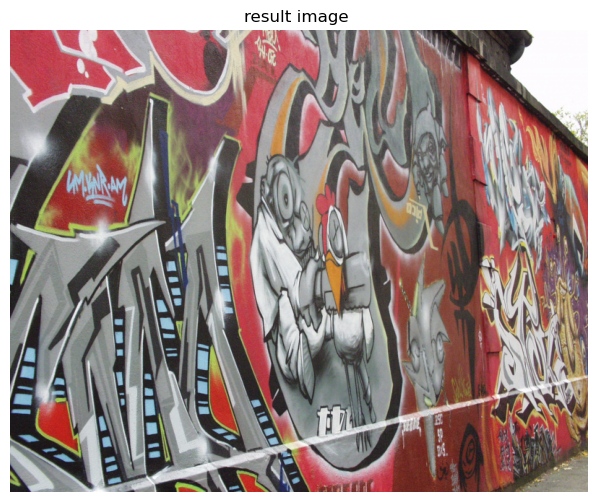

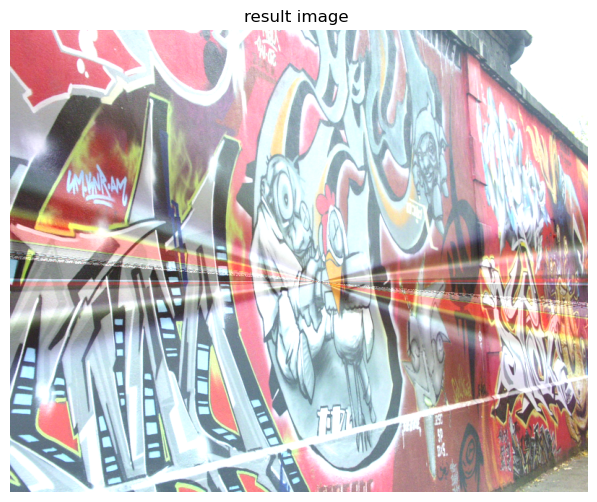

In [66]:
warped_img = cv.warpPerspective(img1, H, (img5.shape[1], img5.shape[0]))
result = cv.addWeighted(img5, 1, warped_img, 0.5, 0)

plt.figure(figsize=(12, 6))
plt.imshow(cv.cvtColor(img5, cv.COLOR_BGR2RGB))
plt.title('result image ')
plt.axis('off')

plt.figure(figsize=(12, 6))
plt.imshow(cv.cvtColor(result, cv.COLOR_BGR2RGB))
plt.title('result image ')
plt.axis('off')

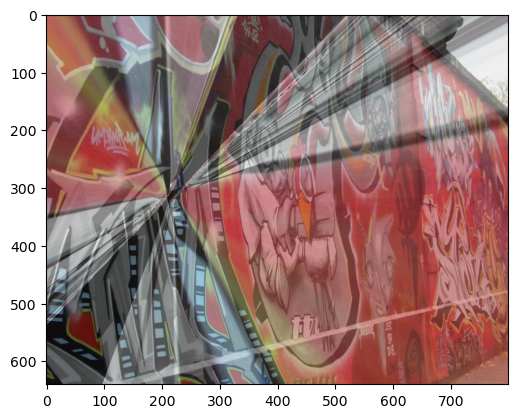

(<matplotlib.image.AxesImage at 0x1bec5aa8f10>, None)

In [43]:
# # Warp img1 to align with img5 using the homography matrix
# h, w, _ = img1.shape
# img1_warped = cv.warpPerspective(img1, H, (w, h))

# # Create a blank canvas to hold the stitched image
# stitched_image = np.zeros_like(img1_warped)
# stitched_image[:h, :w] = img5

# # Stitch the warped image1 onto the canvas
# alpha = 0.5  # Blending factor to smooth the transition
# stitched_image = cv.addWeighted(stitched_image, alpha, img1_warped, 1 - alpha, 0)

# # Show the final stitched image
# plt.imshow(cv.cvtColor(stitched_image, cv.COLOR_BGR2RGB)), plt.show()

   6.2544644e-01   5.7759174e-02   2.2201217e+02
   2.2240536e-01   1.1652147e+00  -2.5605611e+01
   4.9212545e-04  -3.6542424e-05   1.0000000e+00
